In [175]:
# pip install opencv-python
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from utils import label_map_util
from utils import visualization_utils as vis_util
import tensorflow as tf

%matplotlib inline  

In [323]:
# download serialized model & labels: https://github.com/datitran/Object-Detector-App/tree/master/object_detection
tf_model_name = 'ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb'
label_name = 'mscoco_label_map.pbtxt'
path_to_model_ckpt = os.path.join('./models', tf_model_name)
path_to_labels = os.path.join('./models', label_name)
NUM_CLASSES = 90

In [324]:
# load labels
label_map = label_map_util.load_labelmap(path_to_labels)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES,
                                                            use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [249]:
# grab single frame from notebook camera
def capture_single_image(camera_source = 0, width = 480, heoght = 360):
    stream = cv2.VideoCapture(camera_source)
    stream.set(cv2.CAP_PROP_FRAME_WIDTH, width)
    stream.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
    time.sleep(1)
    (grabbed, frame) = stream.read()    
    stream.release()
    if grabbed:
        return frame
    else:
        return None

In [321]:
# load tf graph from pb
def load_tf_graph_from_protobuf(pb_path):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(pb_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return detection_graph

In [322]:
# detect objects
def detect_objects(image_np, sess, detection_graph):
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

    # Each box represents a part of the image where a particular object was detected.
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    # Actual detection.
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})

    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        use_normalized_coordinates=True,
        line_thickness=8)
    
    return image_np

In [333]:
from PIL import Image

# load image from file
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    try:
        return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
    except ex as Exception:        
        np_image = np.array(image.getdata()).reshape((im_height, im_width, 4)).astype(np.uint8)
        return np_image[:,:,0:3]

In [325]:
# restore tf graph from model
model_graph = load_tf_graph_from_protobuf(path_to_model_ckpt)
# create tf session
sess = tf.Session(graph=model_graph)

In [ ]:
# capture image from came
frame = capture_single_image()
labled_frame = detect_objects(frame, sess, model_graph)
plt.imshow(labled_frame)

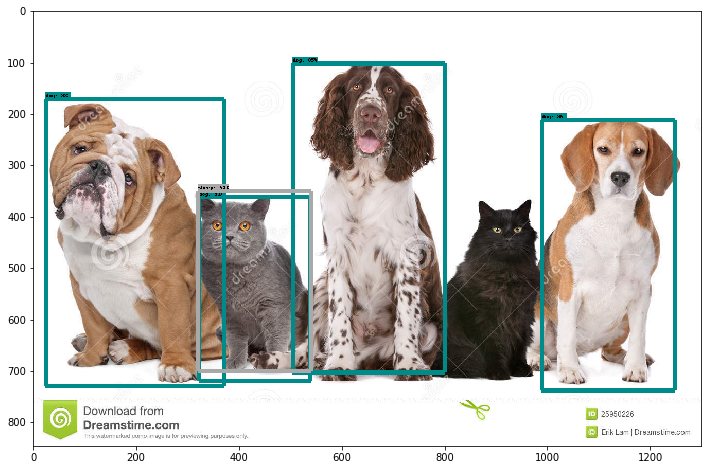

In [331]:
img = Image.open('images/group-cats-dogs-25950226.jpg')
np_image = load_image_into_numpy_array(img)
labled_frame = detect_objects(np_image[:,:,0:3], sess, model_graph)
IMAGE_SIZE = (12, 8)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(labled_frame)